## 2.	Creación de Modelos Predictivos

### 2.1. Regresión lineal
Tienes un dataset con las siguientes columnas:
- Horas_estudio
- Notas_examen

Instrucciones:
- Entrena un modelo de regresión lineal para predecir las Notas_examen en función de las Horas_estudio.
- Muestra el coeficiente de determinación R2R^2R2 del modelo y realiza una predicción para un estudiante que ha estudiado 5 horas.



Vamos a crear las 2 variables de forma aleatoria para el ejercicio. 

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [58]:
# Semilla para reproducibilidad
np.random.seed(42)

# Generar datos
n = 1000

# Horas de estudio entre 0 y 10 horas (distribución uniforme)
horas_estudio = np.random.uniform(0, 10, n)

# Notas normales entre 0 y 5. siendo 0 la peor nota y y 5 la maxima (se asume normalidad en los datos)
notas_examen = np.abs(np.random.normal(0, 5, n))
notas_examen = np.clip(notas_examen,0,5).round(1)

# Crear DataFrame
data = pd.DataFrame({
    'horas_estudio': horas_estudio,
    'notas_examen': notas_examen
})

Text(46.15625, 0.5, 'Notas de examen')

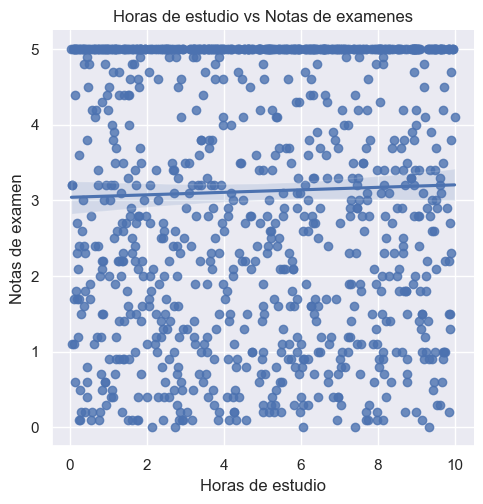

In [59]:
sns.lmplot(
    data=data,
    x="horas_estudio", y="notas_examen"
    )
plt.title('Horas de estudio vs Notas de examenes')
plt.xlabel('Horas de estudio')
plt.ylabel('Notas de examen')

In [60]:
# Separar características y variable objetivo
X = data.drop('notas_examen', axis=1)
y = data['notas_examen']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocesador (escalado)
    ('regresion', LinearRegression(random_state=42)) 
    ])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Obtener las probabilidades de predicción
y_pred = pipeline.predict(X_test)

# Calcular precisión, recall y average precision
r2 = r2_score(y_test, y_pred)
print(f"R² en test: {r2:.4f}")

R² en test: -0.0054


Como se observa el R² es un valor negativo (-0.0054) y esto nos indica varias cosas:
1. Usar variables aleatorias para el entrenamiento de un modelo puede generar que este no tenga el mejor performance. 
2. Un modelo con una sola variable explicativa puede ser insuficiente para explicar dicho fenomeno, es decir, no se puede concluir con suficiente evidencia que el numero de horas de estudio puedan mejorar las notas en los examenes. En parte explicado por el punto anterior (aleatoriedad en los datos) y porque como ya se mencionó al principio no puede ser una sola variable determinasta la que explique este fenomeno. 
3. De esta misma manera, se puede decir teoricamente que no hay relación lineal entre las horas de estudio y las notas finales. Eventualmente, se podria forzar las variables construidas para que así fuese, es decir, al momento de crear nuestra variable respuesta (notas examen) que sea el resultado de alguna configuración lineal del numero de horas (tipo una multiplicación, una suma o división)

Si quisieramos construir nuestra set de datos con esta relación podriamos pensar en la siguiente forma:
Que la nota promedio de todos los estudiantes es de 2.5 y que está se ve incrementanda en 0.5 por cada 1.5horas adicionales de estudio, tipo un costo marginal. Es decir, si dedicas una 1.5h de mas a estudiar puedes obtener media decima de mas en tu nota, lo contrario si no dedicas dicha 1.5h de estudio.

Veamoslo así:

In [76]:
ruido = np.random.normal(0, 1.5, n)  # ruido con desviación estándar de 1.5
notas_examen_1 = 2.5 + 0.5 * horas_estudio + ruido
notas_examen_1 = np.clip(notas_examen_1,0,5).round(1)
data1 = pd.DataFrame({
    'horas_estudio': horas_estudio,
    'notas_examen': notas_examen_1
})

### Al graficarlo nuevamente ya se observa cierto grado de relación entre nuestra variable las notas y las horas de estudio

Text(46.15625, 0.5, 'Notas de examen')

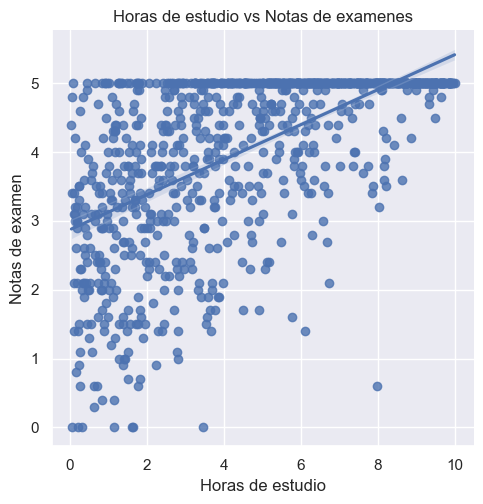

In [77]:
sns.lmplot(
    data=data1,
    x="horas_estudio", y="notas_examen"
    )
plt.title('Horas de estudio vs Notas de examenes')
plt.xlabel('Horas de estudio')
plt.ylabel('Notas de examen')

### Y si entrenamos de nuevo el modelo con este nuevo set de datos

In [78]:
# Separar características y variable objetivo
X = data1.drop('notas_examen', axis=1)
y = data1['notas_examen']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocesador (escalado)
    ('regresion', LinearRegression(random_state=42)) 
    ])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Obtener las probabilidades de predicción
y_pred = pipeline.predict(X_test)

# Calcular precisión, recall y average precision
r2 = r2_score(y_test, y_pred)
print(f"R² en test: {r2:.4f}")

R² en test: 0.3584


### Sin ninguna duda se observa que R² ya es positivo (evidencia el grado de relación positivo entre las variables) y además nos explica de mejor manera el fenomeno que el pasado conjunto de datos de forma aleatoria.

Si quisieramos saber cual podriía ser la nota para un estudiante que dedica 5h de estudio, esta eria la predicción:

In [82]:
# Crear un DataFrame con la nueva observación
nueva_obs = pd.DataFrame({'horas_estudio': [5]})
y_pred = pipeline.predict(nueva_obs)
print(y_pred)

[4.13090322]


### 2.2. Clasificación con árbol de decisión
Dispones de un dataset de clientes con las siguientes columnas:
- Edad
- Ingresos
- Compra_realizada (0: No, 1: Sí)

Instrucciones:
- Entrena un árbol de decisión para predecir si un cliente realizará una compra en función de su edad e ingresos.
- Muestra la importancia de las características y el accuracy del modelo.


Para la creación de estas variables se realizaran 3 supuestos:
1. Para la creación de la variable edad se asumira uniformidad en los datos. Esto quiere decir que no habra "dominancia" en grupo poblacional o de ciertas edades que dominen (en terminos de numero) sobre las otras. Tambien que la edad minima para las compras es la edad productiva de colombia: entre los 18 y 64 años edad. Esto es un supuesto fuerte y veremos -mas adelante- como podria impactar sobre los resultados. 
2. Para los ingresos se tomará como referencia una distribución normal, con media en 2.500.000 COP y con el valor minimo dado por el salario minimo mensual vigente en colombia de 1.423.500 COP y tomando como valor maximo de 10.000.000 COP. 
3. La variable compra es una variable binaria que toma el valor de 0 y 1, donde 0: No Compra y 1: Si compra. En este caso se supone que mas del 70% de las muestras si realiza una compra. Este valor es completamente arbitario y pudo haber sido cualquier otro. Cómo se menciona en el primer punto mas adelante veremos como esto puede afectar en los resultados del modelo.

In [110]:

np.random.seed(42)  # semilla

n = 1000  # Observaciones

# Edad: valores entre 18 y 64 años 
edad = np.random.randint(18, 65, size=n)

# Ingresos: distribución normal truncada entre 1.423.500 y 10.000.000 (media 2.500.000)
ingresos = np.clip(np.random.normal(loc=2500000, scale=200000, size=n), 1423500, 10000000)

# Compra_realizada: variable binaria con cierta probabilidad (ej: 60% sí)
compra_realizada = np.random.choice([0, 1], size=n, p=[0.3, 0.7])

# Crear DataFrame
transaccion = pd.DataFrame({
    'edad': edad,
    'ingresos': ingresos,
    'compra_realizada': compra_realizada
})

print(transaccion.head())


   edad      ingresos  compra_realizada
0    56  2.701259e+06                 1
1    46  2.384622e+06                 1
2    32  2.667138e+06                 0
3    60  2.274059e+06                 0
4    25  2.605961e+06                 1


Text(54.147694444444454, 0.5, 'Ingresos')

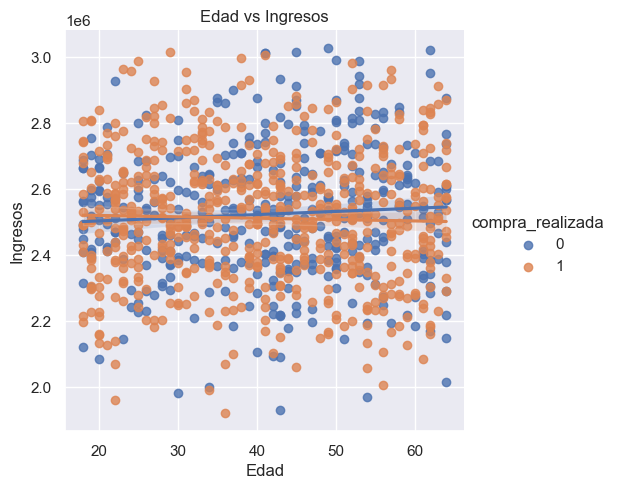

In [97]:
sns.lmplot(
    data=transaccion,
    x="edad", y="ingresos",hue="compra_realizada"
    )
plt.title('Edad vs Ingresos')
plt.xlabel('Edad')
plt.ylabel('Ingresos')

In [111]:
# Separar características y variable objetivo
X = transaccion.drop('compra_realizada', axis=1)
y = transaccion['compra_realizada']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

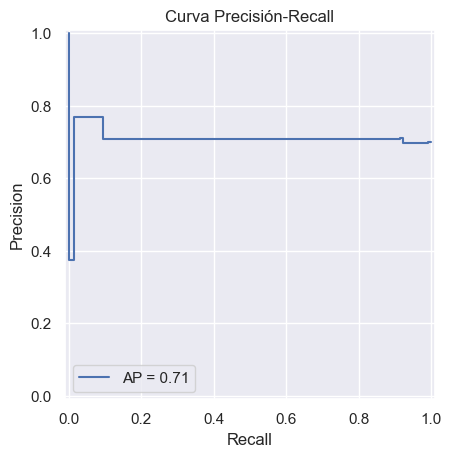

In [120]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocesador (escalado)
    ('classifier', DecisionTreeClassifier(random_state=42)) 
    ])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Hiperparámetros a probar (con prefijo del paso del pipeline)
param_grid = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

#Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Entrenamiento
grid_search.fit(X_train, y_train)

# Obtener las probabilidades de predicción
y_scores = grid_search.predict_proba(X_test)[:, 1] 

# Calcular precisión, recall y average precision
precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)


# Trazar la curva de Precisión-Recall
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
disp.plot()
plt.title("Curva Precisión-Recall")
plt.show()

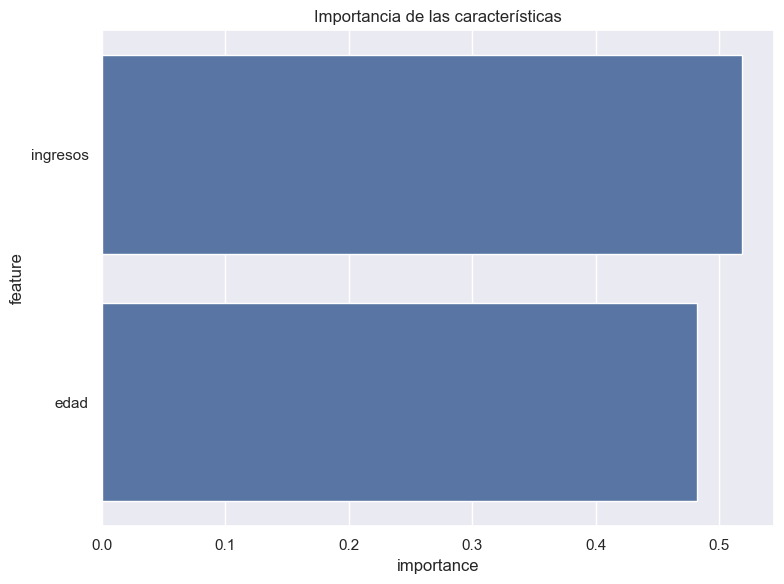

In [124]:
# Obtener el mejor estimador del grid search
best_pipeline = grid_search.best_estimator_

# Extraer el clasificador entrenado (árbol de decisión)
best_model = best_pipeline.named_steps['classifier']

# Obtener las importancias
importances = best_model.feature_importances_

# Si tus datos de entrada son un DataFrame, puedes obtener los nombres de las columnas:
feature_names = X_train.columns  # Asegúrate de que X_train sea un DataFrame

# Crear un DataFrame con las importancias
import pandas as pd
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)



import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Importancia de las características')
plt.tight_layout()
plt.show()


Como se mencionaba previamente el hecho de hacer que la distribución de nuestra variable binaria con un desbalance de 70-30 (70 si compran y 30 No lo hacen) tuvo efectos significativos sobre nuestra metrica de evaluación del modelo como lo fue la Curva PR (Precision-Recall) que para los casos -como este caso- donde hay un marcado desblance los resultados del modelo serian muy similares. Tambien podria probar que realizar un tunneo de los parametros mejora el performance de los modelos. Ya que si se corre el modelo sin un tanteo de parametros y una validacón cruzada los resultados del performance serian inferiores. 

Adicionalmente, se puede obsservar que los ingresos tiene un poco mas del 50% de importancia dentro del dataset y el restante la edad. En modelos con un mayor numero de features se espera que no haya tal dominancia de una o unas variables dentro de la analisis, sino que se espera que haya cierta parsimonia dentro del conjunto de datos seleccionado; puesto que esto puede generar sesgos en el modelo y que el proceso estocastico este ponderado por una sola variable. 

Como se puede evidenciar en los siguientes resultados: 

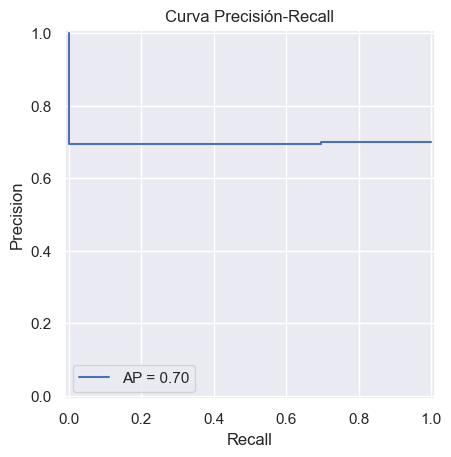

In [118]:
# Pipeline con hiperparámetros definidos manualmente
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocesador (escalado)
    ('classifier', DecisionTreeClassifier(
        random_state=42
    )) 
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Obtener las probabilidades de predicción (clase positiva)
y_scores = pipeline.predict_proba(X_test)[:, 1]  # solo la probabilidad de la clase positiva

# Calcular precisión, recall y average precision
precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

# Trazar la curva de Precisión-Recall
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
disp.plot()
plt.title("Curva Precisión-Recall")
plt.show()

Otro hecho relevante es que las pocas variables dependientes del modelo (Edad e Ingresos) no son completamente determinantes sobre si una persona hará una compra o no. En este tipo de escenario se sabe que son muchas las variables las que pueden influir (tanto de forma positiva como negativa) sobre las compras de los usuarios. 